# Лабораторная работа №4. Реализация приложения по распознаванию номеров домов

### Данные 1: В работе предлагается использовать набор данных notMNIST, который состоит из изображений размерностью 28×28 первых 10 букв латинского алфавита (A … J, соответственно). Обучающая выборка содержит порядка 500 тыс. изображений, а тестовая – около 19 тыс.
### Данные 2: Набор изображений из Google Street View с изображениями номеров домов, содержащий 10 классов, соответствующих цифрам от 0 до 9.

Ниже будут прописаны все библиотеки, которые мы используем в лабораторной работе

In [1]:
import pathlib
import requests
import tarfile
import os
import PIL
import PIL.Image
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras

import scipy.io
import pandas as pd
from collections import Counter
from skimage.color import rgb2gray

C:\Users\aliakseik\AppData\Local\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


### Задание 1. Реализация глубокой нейронной сети, обученной на синтетических данных notMNIST

#### Здесь мы загрузим данные, избавимся от дупликатов и перемешаем данные. Код взят из лабораторной работы 3

#### Загрузим данные

In [2]:
url = "https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz"

download_dir = "notMNIST_dataset_big"


if not os.path.exists(download_dir):
    os.makedirs(download_dir)

response = requests.get(url)
with open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "wb") as f:
    f.write(response.content)

with tarfile.open(os.path.join(download_dir, "notMNIST_large.tar.gz"), "r:gz") as tar:
    tar.extractall(download_dir)

print("Данные успешно загружены и извлечены.")

Данные успешно загружены и извлечены.


In [3]:
data_dir = os.path.join(download_dir, "notMNIST_large")
data_dir = pathlib.Path(data_dir)
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

#### Перед тем как делить данные на выборки, "перемешаем" между собой картинки из разных папок собой, чтобы не получилось так, что в одной выборке все буквы одного из классов, а в другой выборке букв этого класса вообще нет


In [4]:
image_paths = list(data_dir.glob("*/*.png"))
image_paths.sort()
random.shuffle(image_paths)

#### Избавимся от дупликатов изображений

Для начала напишем функцию для вычисления дифференциального хеша (dHash) изображения, чтобы было проще убрать дупликаты

In [5]:
def dhash(image, hash_size=8):
    # Изменяем размер изображения до размера hash_size + 1 на hash_size  и преобразуем его в оттенки серого
    resized = cv2.resize(image, (hash_size + 1, hash_size))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    hash_string = ""
    
    # Сравниваем пиксели по строкам
    for i in range(hash_size):
        for j in range(hash_size):
            if gray[i, j] > gray[i, j + 1]:
                hash_string += "1"
            else:
                hash_string += "0"

    return hash_string

Создадим словарь, где ключами будут все возможные различные кэши изображений, а значениями будут списки путей к картинкам, у которых конкретный кэш

In [6]:
image_hashes = {}
for image_path in image_paths:
    image = cv2.imread(str(image_path))
    if image is not None:
        if image.shape[0] != 0 and image.shape[1] != 0:
            hashed_image = dhash(image)

            different_hashes = image_hashes.get(hashed_image, [])
            different_hashes.append(image_path)
            
            image_hashes[hashed_image] = different_hashes

А уже следующей функцией удалим все дупликаты изображений и оставим только первые картинки из повторяющихся

In [7]:
images_whithout_duplicates = []
hash_len = 0

for (different_hashes, hashes_paths) in image_hashes.items():
    images_whithout_duplicates.append(hashes_paths[0])
    hash_len += len(hashes_paths)
    
print(f"Было удалено {hash_len - len(images_whithout_duplicates)} дупликатов")

Было удалено 176474 дупликатов


####  Разделим выборку

In [9]:
data = []
labels = []
for file in images_whithout_duplicates:
    image = cv2.imread(str(file))
    
    # Достаём в какой папке (и к какому классу соответственно, относится изображение)
    label = str(file.parent).split('\\')[-1]
    
    # с помощью reshape преобразуем изображение в одномерный массив и нормализуем каждый из 
    # полученных веторов с помощью деления его на 255. Таким образом все числа в массиве от 0 до 1
    # data.append(image.reshape(-1)/255)
    
    data.append(image/255)
    
    # Добавляем в список labels индекс буквы (0-A, 1-B, 2-C,...)
    labels.append(classes.index(label))

In [10]:
print(len(data))

352640


In [11]:
#x_train, x_test, y_train, y_test = train_test_split(np.array(data[:220000], np.float32), np.array(labels[:220000], np.float32),
#                                                    test_size=20000/220000, random_state=42)


x_train, x_test, y_train, y_test = train_test_split(np.array(data[:352000], np.float32), np.array(labels[:352000], np.float32),
                                                    test_size=35200/352000, random_state=42)

In [12]:
print(len(x_train))
print(len(x_test))
print(len(y_train))
print(len(y_test))


316800
35200
316800
35200


### Реализация сети 

In [13]:
notmnist_model = keras.Sequential([

    # Первый свёрточный слой с 6 фильтрами (значит столько признаков будут выделять) 
    # и окно размера 5 на 5 пикселей будет переходить
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 3),kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Первый слой пулинга с функцией среднего
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Второй свёрточный слой с 16 фильтрами
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Второй слой пулинга с функцией среднего
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Слой Flatten, который преобразует многомерные данные в одномерный вектор перед подачей их на полносвязный слой
    keras.layers.Flatten(),
    
    # Первый полносвязный слой со 128 нейронами 
    keras.layers.Dense(units=128, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Слой отключения нейронов для борьбы с переобучением
    keras.layers.Dropout(0.5),
    
    # Второй полносвязный слой с 64 нейронами 
    keras.layers.Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

#### "Скомпилируем" нашу модель нейронной сети

In [14]:
notmnist_model.compile(optimizer=keras.optimizers.SGD(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

#### Обучим нашу модель нейронной сети

In [15]:
history_notmnist_model = notmnist_model.fit(x_train, y_train, epochs=35, validation_split=0.1)

Epoch 1/35
8910/8910 [==============================] - 103s 11ms/step - loss: 1.1654 - accuracy: 0.7408 - val_loss: 0.8730 - val_accuracy: 0.8205
Epoch 2/35
8910/8910 [==============================] - 101s 11ms/step - loss: 0.8668 - accuracy: 0.8135 - val_loss: 0.7516 - val_accuracy: 0.8391
Epoch 3/35
8910/8910 [==============================] - 101s 11ms/step - loss: 0.7636 - accuracy: 0.8287 - val_loss: 0.6697 - val_accuracy: 0.8483
Epoch 4/35
8910/8910 [==============================] - 100s 11ms/step - loss: 0.6934 - accuracy: 0.8385 - val_loss: 0.6185 - val_accuracy: 0.8542
Epoch 5/35
8910/8910 [==============================] - 100s 11ms/step - loss: 0.6457 - accuracy: 0.8453 - val_loss: 0.5788 - val_accuracy: 0.8614
Epoch 6/35
8910/8910 [==============================] - 100s 11ms/step - loss: 0.6122 - accuracy: 0.8495 - val_loss: 0.5610 - val_accuracy: 0.8610
Epoch 7/35
8910/8910 [==============================] - 101s 11ms/step - loss: 0.5882 - accuracy: 0.8531 - val_loss: 0

#### Вычислим точность работы на тестовых данных нашей нейронной сети

In [16]:
_, test_acc = notmnist_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of notmnist_model:', test_acc)

Test accuracy of notmnist_model: 0.8878409266471863


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


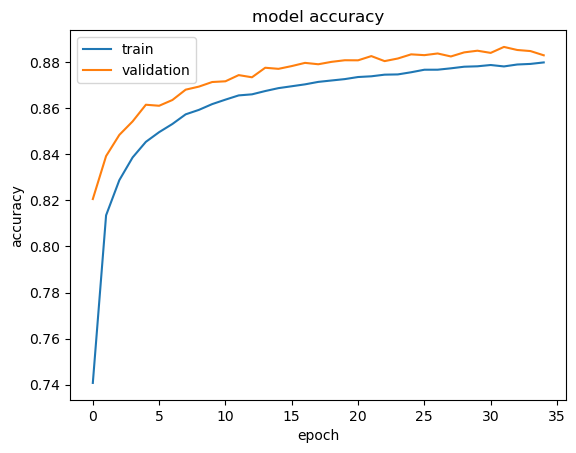

In [17]:
print(history_notmnist_model.history.keys())
# summarize history for accuracy
plt.plot(history_notmnist_model.history['accuracy'])
plt.plot(history_notmnist_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

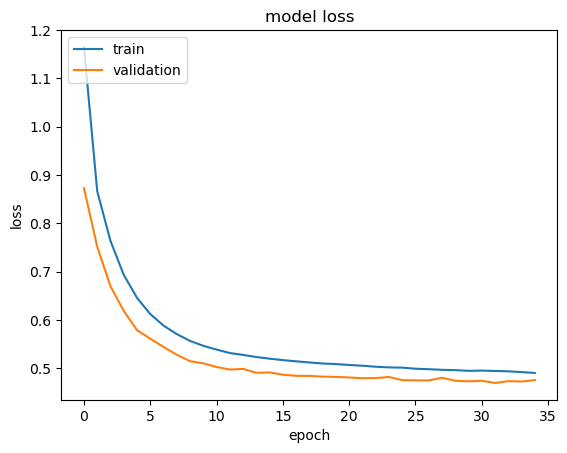

In [18]:
plt.plot(history_notmnist_model.history['loss'])
plt.plot(history_notmnist_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

### Точность у полученной нейронной сети 88,8%


### Задание 2. Обучение полученной модели на реальных данных

### Предварительно загрузив файлы с данными с сайта http://ufldl.stanford.edu/housenumbers, загружаем их сюда.
1. При этом при загрузке данных из формата .mat файла для набора данных SVHN, изображения хранятся в массиве X с осевым порядком (width, height, channels, num_samples). Но для использования этих данных данные изображения  ожидаются в формате (num_samples, width, height, channels). Для этого используем функцию np.transpose для перестановки осей массивов
2. Также преобразуем метки у цифр, которые равны нулю из 10 в 0 

In [273]:
test_data = scipy.io.loadmat('test_32x32.mat')
train_data = scipy.io.loadmat('train_32x32.mat')

x_test = np.array(test_data['X'])
y_test = np.array(test_data['y'])
x_train = np.array(train_data['X'])
y_train = np.array(train_data['y'])

x_test = np.transpose(x_test, (3, 0, 1, 2))
x_train = np.transpose(x_train, (3, 0, 1, 2))

y_test[y_test == 10] = 0
y_train[y_train == 10] = 0

In [274]:
print(f'Размер тренировочных данных: {x_train.shape}, Размер тренировочных меток: {y_train.shape}')
print(f'Размер тестовых данных: {x_test.shape}, Размер тестовых меток: {y_test.shape}')

Размер тренировочных данных: (73257, 32, 32, 3), Размер тренировочных меток: (73257, 1)
Размер тестовых данных: (26032, 32, 32, 3), Размер тестовых меток: (26032, 1)


### Избавимся от дупликатов изображений

In [275]:
def remove_duplicates(x, y):
    # Преобразуем каждое изображение в строку для удобства сравнения
    reshaped_x = x.reshape(x.shape[0], -1)
    df = pd.DataFrame(reshaped_x)
    df['label'] = y
    # Удаляем дубликаты
    df_unique = df.drop_duplicates()
    # Разделяем DataFrame обратно на изображения и метки
    unique_x = df_unique.drop('label', axis=1).values
    unique_y = df_unique['label'].values
    
    return unique_x.reshape(unique_x.shape[0], x.shape[1], x.shape[2], x.shape[3]), unique_y


In [276]:
x_train, y_train = remove_duplicates(x_train, y_train)
x_test, y_test = remove_duplicates(x_test, y_test)

### Проверим сбалансированность классов

In [277]:
train_counter = Counter(y_train)
test_counter = Counter(y_test)

# Расчет процентного соотношения
total_train = len(y_train)
total_test = len(y_test)

train_percentages = {label: (count / total_train) * 100 for label, count in train_counter.items()}
test_percentages = {label: (count / total_test) * 100 for label, count in test_counter.items()}

print("Распределение тренировочных данных в процентах:")
for label, percentage in train_percentages.items():
    print(f"Класс {label}: {percentage:.2f}%")

print("\nРаспределение тестовых данных в процентах:")
for label, percentage in test_percentages.items():
    print(f"Класс {label}: {percentage:.2f}%")

Распределение тренировочных данных в процентах:
Класс 1: 18.92%
Класс 9: 6.36%
Класс 2: 14.45%
Класс 3: 11.60%
Класс 5: 9.39%
Класс 8: 6.89%
Класс 7: 7.64%
Класс 4: 10.18%
Класс 6: 7.82%
Класс 0: 6.75%

Распределение тестовых данных в процентах:
Класс 5: 9.16%
Класс 2: 15.94%
Класс 1: 19.59%
Класс 0: 6.70%
Класс 6: 7.59%
Класс 9: 6.13%
Класс 8: 6.38%
Класс 3: 11.07%
Класс 4: 9.69%
Класс 7: 7.76%


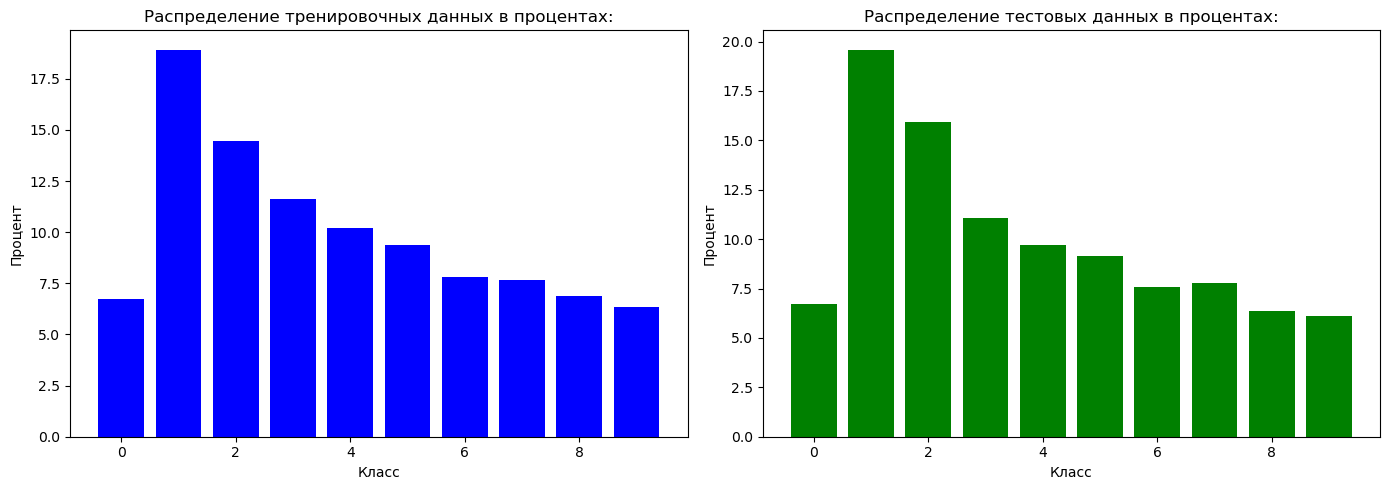

In [278]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].bar(train_percentages.keys(), train_percentages.values(), color='blue')
axes[0].set_title('Распределение тренировочных данных в процентах:')
axes[0].set_xlabel('Класс')
axes[0].set_ylabel('Процент')

axes[1].bar(test_percentages.keys(), test_percentages.values(), color='green')
axes[1].set_title('Распределение тестовых данных в процентах:')
axes[1].set_xlabel('Класс')
axes[1].set_ylabel('Процент')

plt.tight_layout()
plt.show()

### Классы являются не сбалансированными. Сбалансируем их

In [279]:
def balance_classes(x, y):
    # Проверка начального распределения классов
    print("Начальное распределение классов в данных:", Counter(y))

    # Находим класс с наименьшим количеством образцов
    min_class_count = min(Counter(y).values())

    # Создаем новые данные, удаляя лишние образцы из классов большинства
    balanced_X = []
    balanced_y = []
    for label in set(y):
        label_indices = np.where(y == label)[0]
        balanced_indices = np.random.choice(label_indices, min_class_count, replace=False)
        balanced_X.extend(x[balanced_indices])
        balanced_y.extend(y[balanced_indices])

    # Преобразование в numpy arrays
    balanced_X = np.array(balanced_X)
    balanced_y = np.array(balanced_y)

    # Проверка нового распределения классов
    print("Переделанное распределение классов в данных:", Counter(balanced_y))

    # Построение диаграммы распределения классов (процентное соотношение) после ресемплинга
    train_counter_resampled = Counter(balanced_y)
    total_train_resampled = len(balanced_y)
    train_percentages_resampled = {label: (count / total_train_resampled) * 100 for label, count in train_counter_resampled.items()}

    fig, ax = plt.subplots(figsize=(7, 5))
    ax.bar(train_percentages_resampled.keys(), train_percentages_resampled.values(), color='blue')
    ax.set_title('Переделанное распределение классов в данных')
    ax.set_xlabel('Класс')
    ax.set_ylabel('Процент')

    plt.tight_layout()
    plt.show()
    
    return balanced_X, balanced_y

Начальное распределение классов в данных: Counter({1: 13861, 2: 10585, 3: 8497, 4: 7458, 5: 6882, 6: 5727, 7: 5595, 8: 5045, 0: 4948, 9: 4659})
Переделанное распределение классов в данных: Counter({0: 4659, 1: 4659, 2: 4659, 3: 4659, 4: 4659, 5: 4659, 6: 4659, 7: 4659, 8: 4659, 9: 4659})


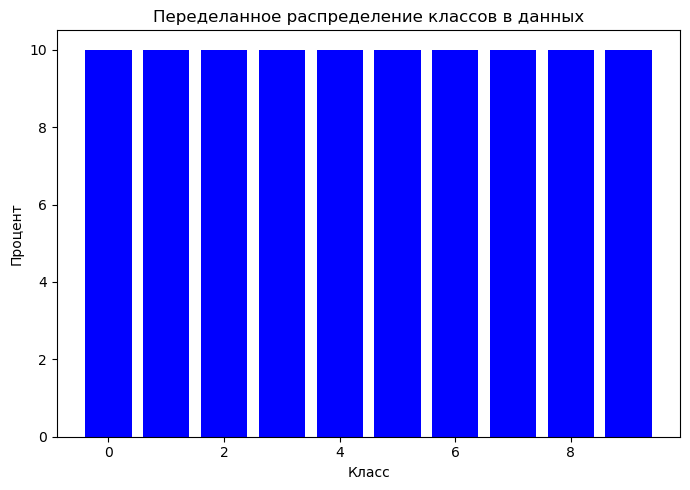

Начальное распределение классов в данных: Counter({1: 5099, 2: 4149, 3: 2882, 4: 2523, 5: 2384, 7: 2019, 6: 1977, 0: 1744, 8: 1660, 9: 1595})
Переделанное распределение классов в данных: Counter({0: 1595, 1: 1595, 2: 1595, 3: 1595, 4: 1595, 5: 1595, 6: 1595, 7: 1595, 8: 1595, 9: 1595})


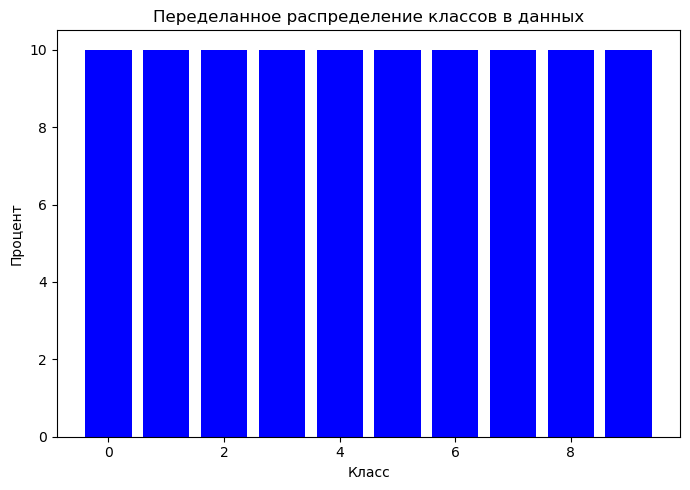

In [280]:
x_train, y_train = balance_classes(x_train, y_train)
x_test, y_test = balance_classes(x_test, y_test)

### Подготовим наши данные. Переведём в серый и нормализуем их

In [281]:
x_train = rgb2gray(x_train)
x_test = rgb2gray(x_test)

x_train = x_train.reshape((-1, 32, 32, 1))
x_test = x_test.reshape((-1, 32, 32, 1))


#x_train = x_train / 255.0
#x_test = x_test / 255.0

print(x_train, x_test)

[[[[ 91.9602]
   [ 93.373 ]
   [ 93.1342]
   ...
   [ 57.8587]
   [ 78.1125]
   [ 86.5955]]

  [[ 92.9601]
   [ 93.96  ]
   [ 93.1342]
   ...
   [ 59.1467]
   [ 76.8137]
   [ 86.4106]]

  [[ 93.96  ]
   [ 97.0737]
   [ 92.6612]
   ...
   [ 62.3205]
   [ 76.5148]
   [ 86.2966]]

  ...

  [[ 97.4157]
   [ 93.1711]
   [ 70.6294]
   ...
   [ 92.3731]
   [ 92.4162]
   [ 97.1168]]

  [[ 97.8286]
   [ 97.6545]
   [ 82.525 ]
   ...
   [ 96.4867]
   [ 97.0136]
   [ 98.0135]]

  [[ 98.1275]
   [100.1273]
   [ 88.1824]
   ...
   [ 98.1984]
   [ 97.8995]
   [ 97.8995]]]


 [[[114.0919]
   [113.9779]
   [114.1628]
   ...
   [ 85.2088]
   [ 80.9103]
   [ 78.1386]]

  [[106.0927]
   [107.9785]
   [111.9781]
   ...
   [ 85.2088]
   [ 81.0243]
   [ 78.2526]]

  [[ 90.0943]
   [ 95.0938]
   [106.0927]
   ...
   [ 84.138 ]
   [ 80.2524]
   [ 79.2525]]

  ...

  [[ 14.3576]
   [ 22.4708]
   [ 40.469 ]
   ...
   [ 52.6573]
   [ 51.9563]
   [ 52.2552]]

  [[ 27.5412]
   [ 37.7682]
   [ 59.407 ]
   ...
   [ 

In [282]:
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)
print(y_train)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


### Разделим тестовые данные на валидационные и тестовые и создадим и обучим модель

In [283]:
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

In [290]:
svhn_model = keras.Sequential([

    # Первый свёрточный слой с 6 фильтрами (значит столько признаков будут выделять) 
    # и окно размера 5 на 5 пикселей будет переходить
    keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1),kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Первый слой пулинга с функцией среднего
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Второй свёрточный слой с 16 фильтрами
    keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Второй слой пулинга с функцией среднего
    keras.layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Слой Flatten, который преобразует многомерные данные в одномерный вектор перед подачей их на полносвязный слой
    keras.layers.Flatten(),
    
    # Первый полносвязный слой со 128 нейронами 
    keras.layers.Dense(units=128, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Слой отключения нейронов для борьбы с переобучением
    keras.layers.Dropout(0.5),
    
    # Второй полносвязный слой с 64 нейронами 
    keras.layers.Dense(units=64, activation='relu',kernel_regularizer=tf.keras.regularizers.L2(0.001)),
    
    # Возвращает массив из десяти вероятностных оценок, сумма которых равна 1. Каждый узел содержит оценку, которая 
    # указывает вероятность того, что текущее изображение принадлежит одному из 10 классов.
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [291]:
learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.001,
        decay_steps=10000,
        decay_rate=0.9,
        staircase=True
    )

In [292]:
svhn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics=["accuracy"]
    )

In [293]:
history_svhn_model = svhn_model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Epoch 1/20
1456/1456 [==============================] - 26s 17ms/step - loss: 1.5705 - accuracy: 0.5809 - val_loss: 0.9792 - val_accuracy: 0.7671
Epoch 2/20
1456/1456 [==============================] - 25s 17ms/step - loss: 0.9822 - accuracy: 0.7555 - val_loss: 0.8556 - val_accuracy: 0.7970
Epoch 3/20
1456/1456 [==============================] - 24s 17ms/step - loss: 0.8721 - accuracy: 0.7845 - val_loss: 0.7898 - val_accuracy: 0.8093
Epoch 4/20
1456/1456 [==============================] - 24s 16ms/step - loss: 0.8050 - accuracy: 0.8032 - val_loss: 0.7419 - val_accuracy: 0.8237
Epoch 5/20
1456/1456 [==============================] - 24s 16ms/step - loss: 0.7522 - accuracy: 0.8190 - val_loss: 0.7270 - val_accuracy: 0.8285
Epoch 6/20
1456/1456 [==============================] - 24s 17ms/step - loss: 0.7273 - accuracy: 0.8289 - val_loss: 0.6905 - val_accuracy: 0.8408
Epoch 7/20
1456/1456 [==============================] - 23s 16ms/step - loss: 0.7036 - accuracy: 0.8327 - val_loss: 0.6772 -

In [294]:
_, test_acc = svhn_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy of svhn_model:', test_acc)

Test accuracy of svhn_model: 0.8615673780441284


### Построим графики точности и потерь тренировочных и валидационных данных

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


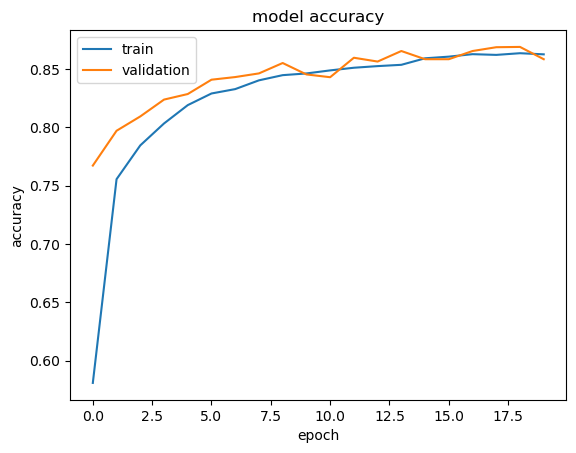

In [295]:
print(history_svhn_model.history.keys())
# summarize history for accuracy
plt.plot(history_svhn_model.history['accuracy'])
plt.plot(history_svhn_model.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

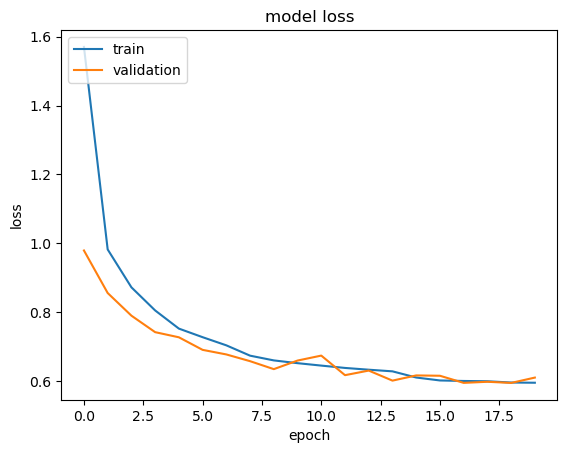

In [296]:
plt.plot(history_svhn_model.history['loss'])
plt.plot(history_svhn_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

## Для дальнейшего использования полученной модели в мобильном приложении преобразуем keras-модель в TFLite-модель и сохраним в файл

In [299]:
converter = tf.lite.TFLiteConverter.from_keras_model(svhn_model)
tflite_model = converter.convert()

with open('svhn_model.tflite', "wb") as f:
    f.write(tflite_model)
print('Модель сохранена успешно')

INFO:tensorflow:Assets written to: C:\Users\ALIAKS~1\AppData\Local\Temp\tmpveplrt6n\assets


INFO:tensorflow:Assets written to: C:\Users\ALIAKS~1\AppData\Local\Temp\tmpveplrt6n\assets


Модель сохранена успешно


## Продемонстрируем полученные результаты

Работа демонстрирует как успешные так и неуспешные результаты :)

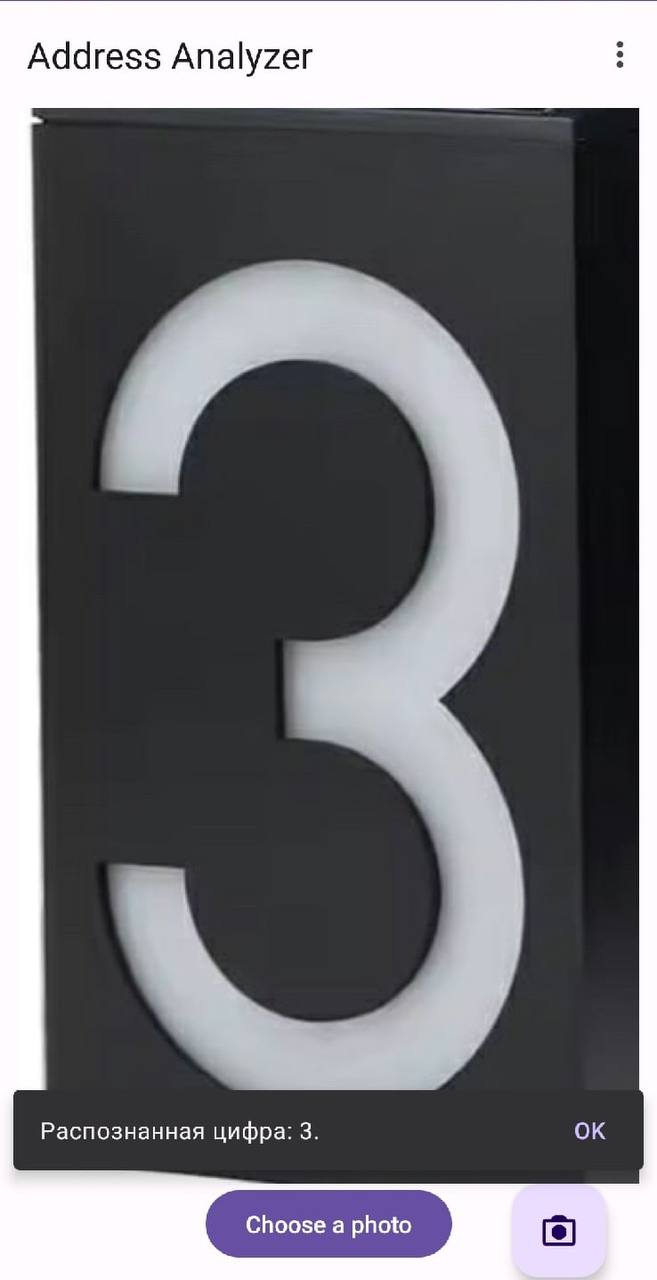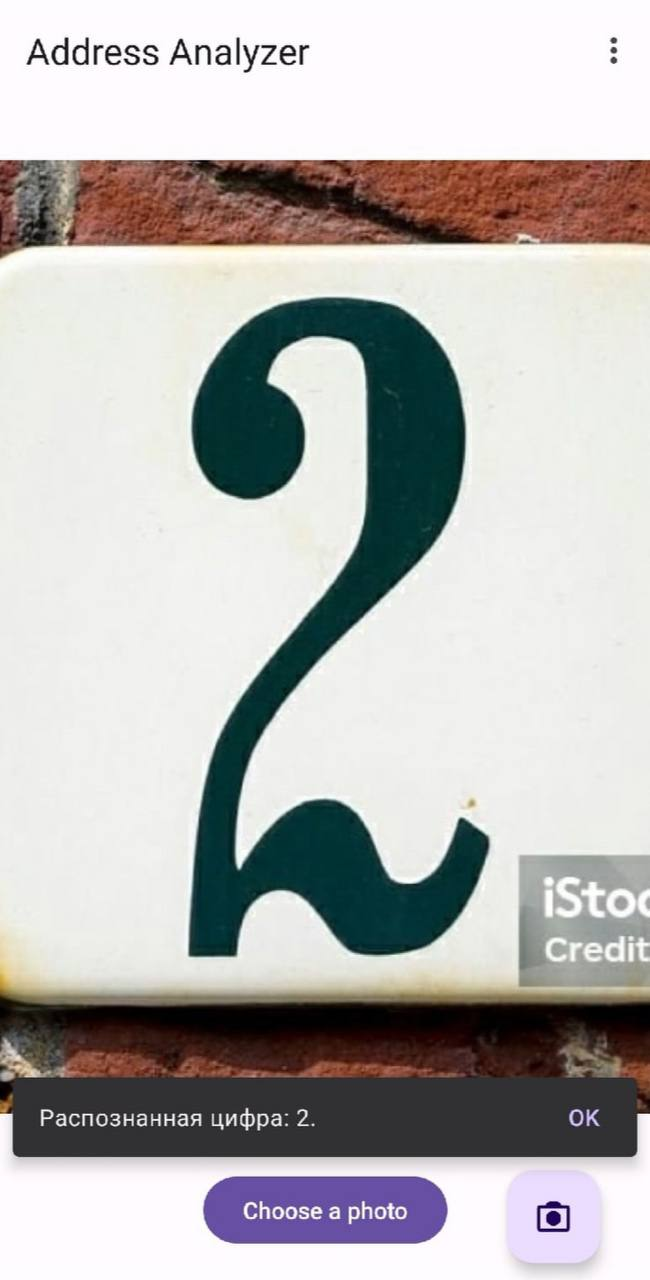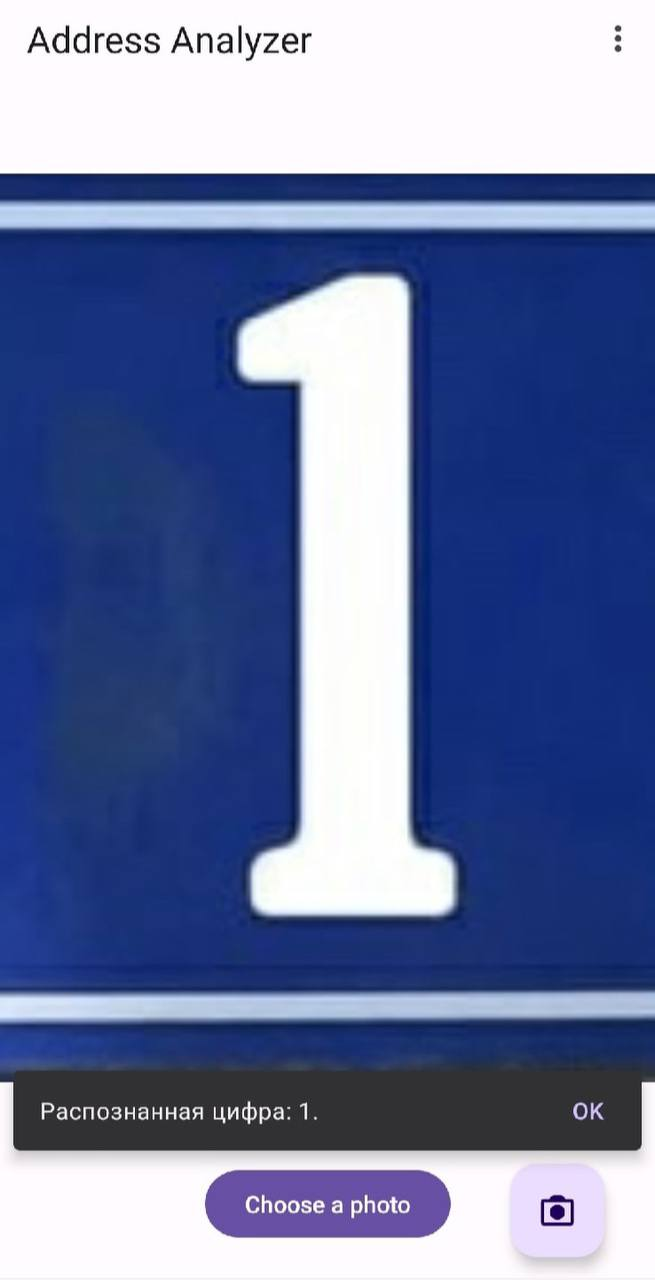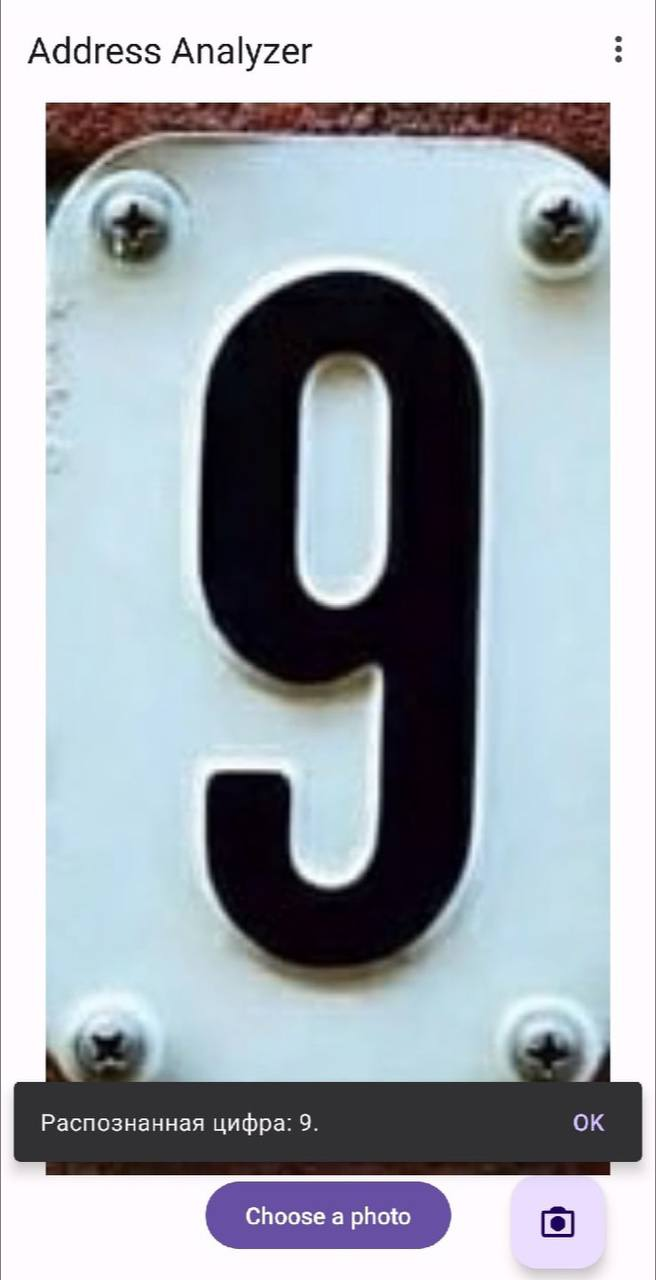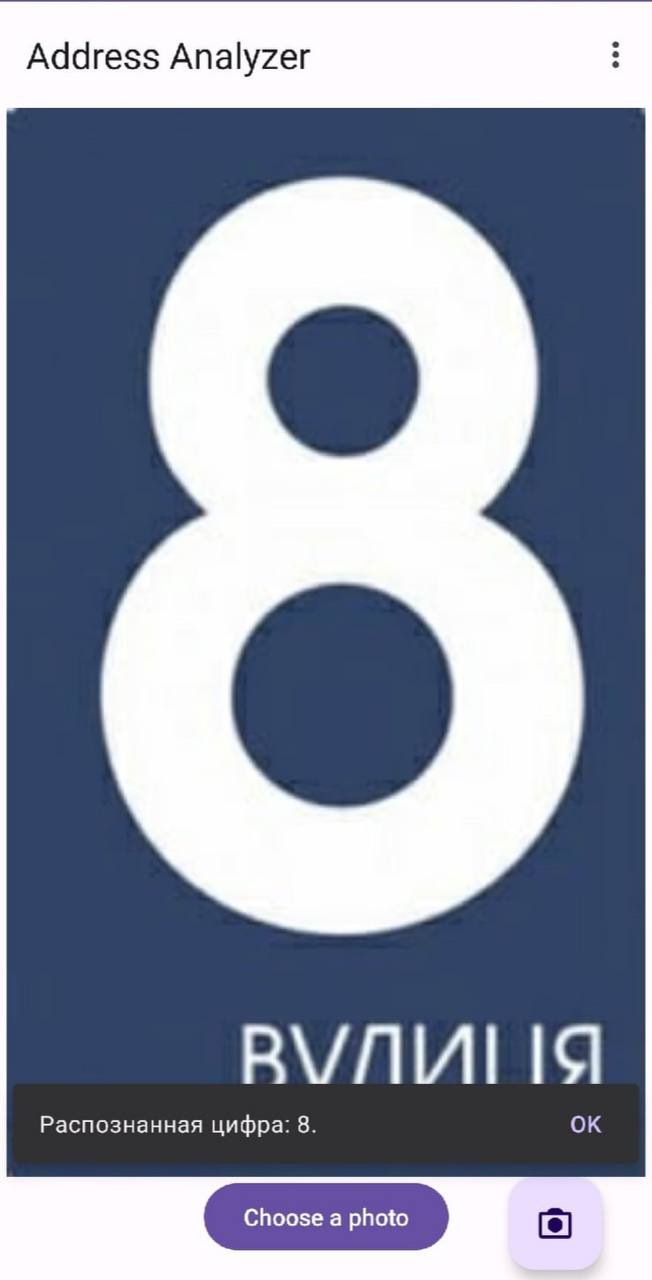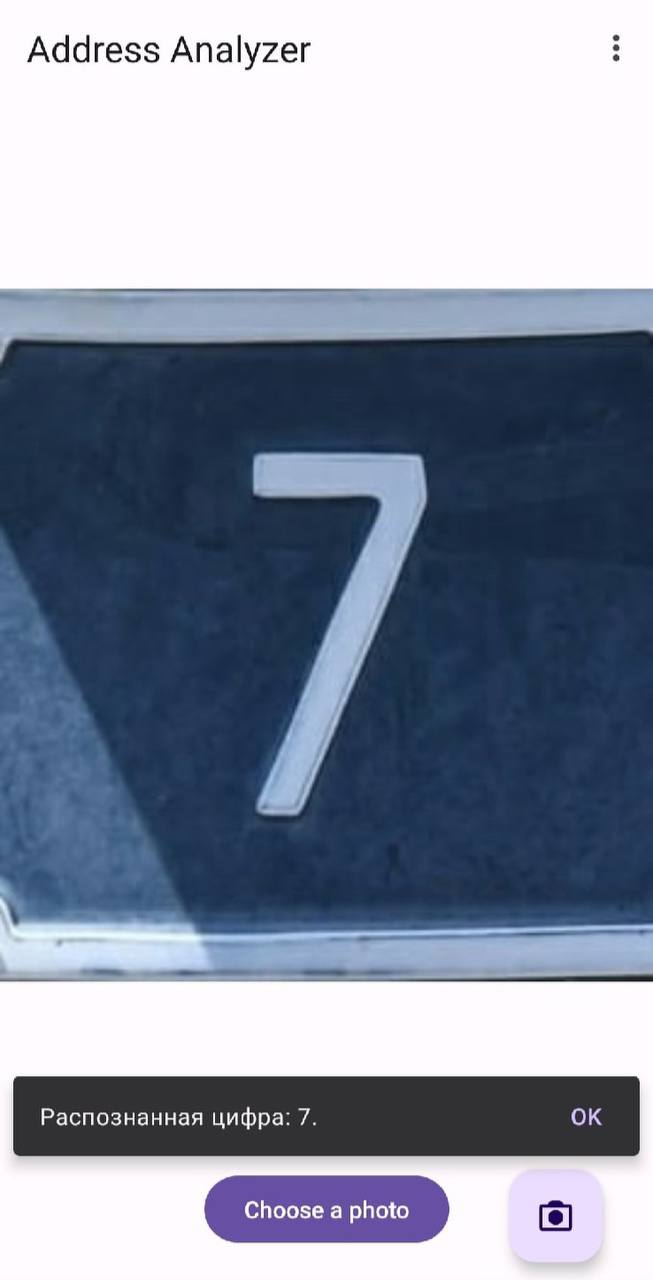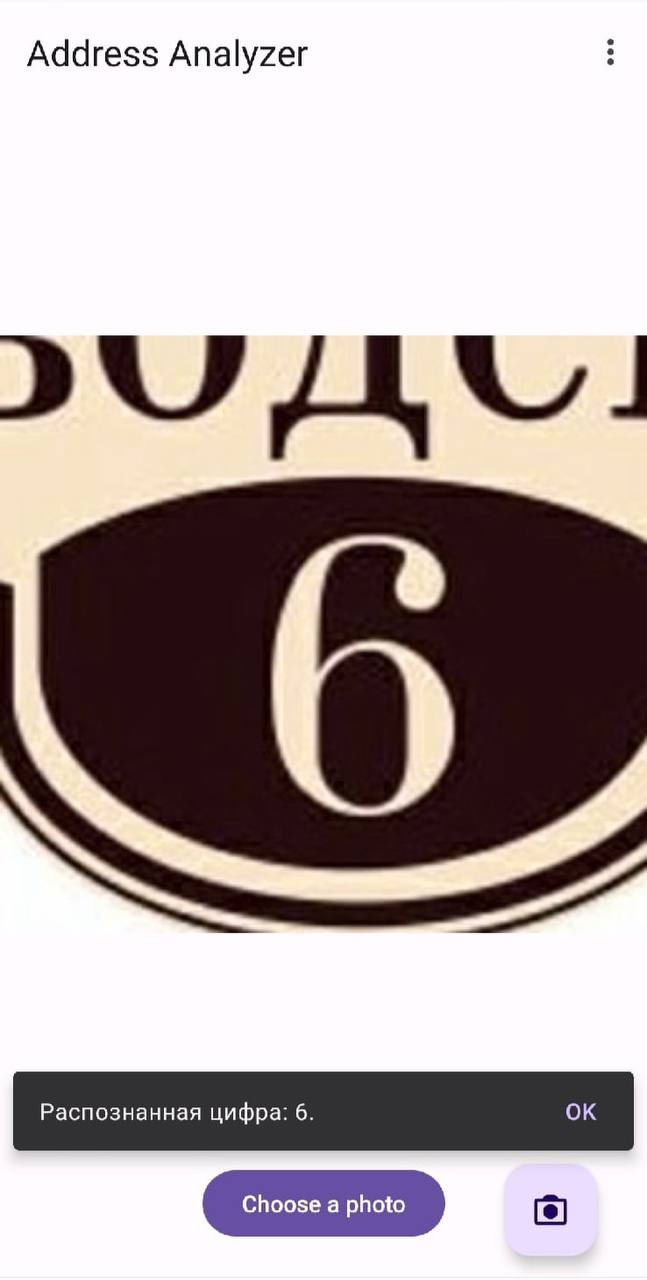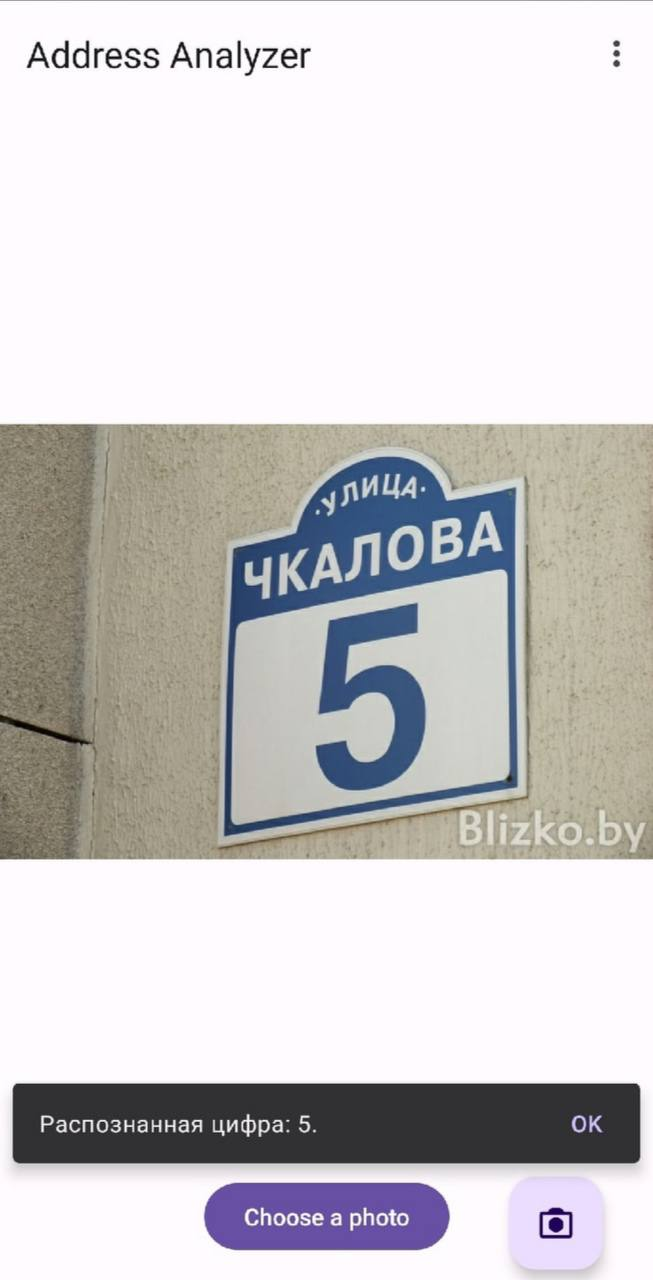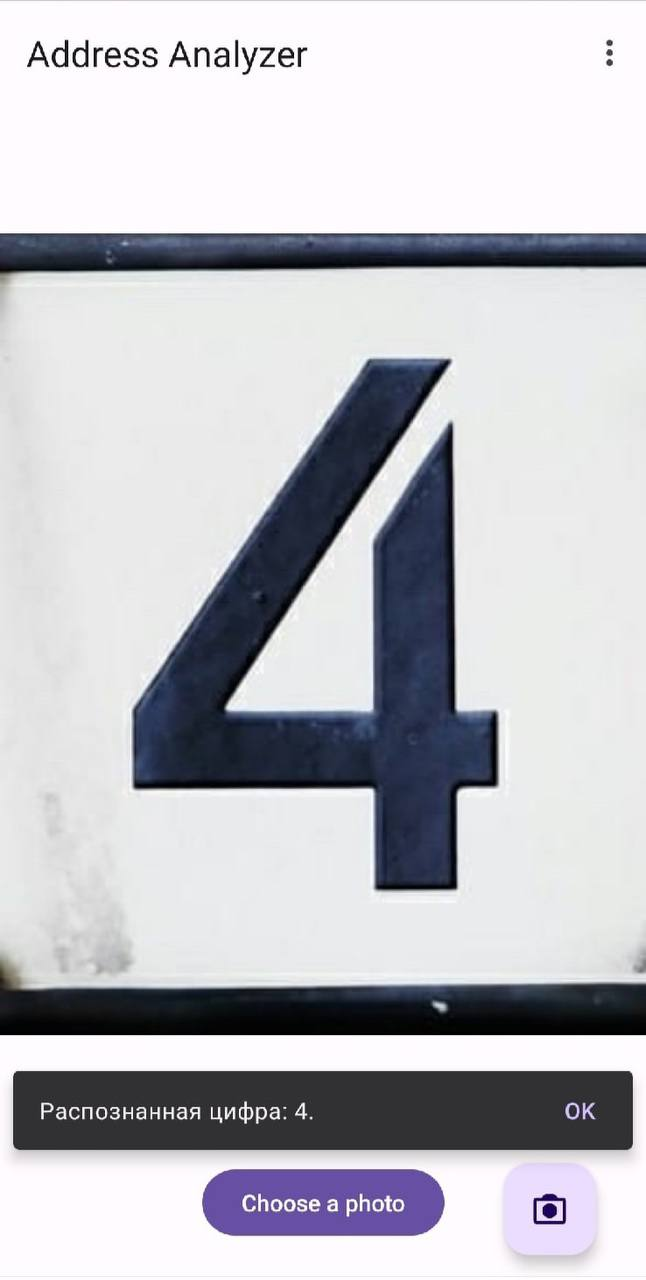